In [17]:
!pip3 install rpy2 torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [19]:
%matplotlib inline

In [20]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [22]:
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.16")

R[write to console]: Bioconductor version 3.16 (BiocManager 1.30.19), R 4.2.2 (2022-10-31 ucrt)

R[write to console]: Installation paths not writeable, unable to update packages
  path: C:/Program Files/R/R-4.2.2/library
  packages:
    boot, Matrix

R[write to console]: Old packages: 'DelayedArray', 'GenomicRanges'



Update all/some/none? [a/s/n]: 
  There are binary versions available but the source versions are later:
              binary source needs_compilation
DelayedArray  0.23.2 0.24.0              TRUE
GenomicRanges 1.49.0 1.50.1              TRUE

  Binaries will be installed


R[write to console]: trying URL 'https://bioconductor.org/packages/3.16/bioc/bin/windows/contrib/4.2/DelayedArray_0.23.2.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2449113 bytes (2.3 MB)

R[write to console]: downloaded 2.3 MB


R[write to console]: trying URL 'https://bioconductor.org/packages/3.16/bioc/bin/windows/contrib/4.2/GenomicRanges_1.49.0.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2106331 bytes (2.0 MB)

R[write to console]: downloaded 2.0 MB




package 'DelayedArray' successfully unpacked and MD5 sums checked
package 'GenomicRanges' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\iwish\AppData\Local\Temp\Rtmp0OVUVu\downloaded_packages


In [23]:
%%R
BiocManager::install("splatter")

R[write to console]: Bioconductor version 3.16 (BiocManager 1.30.19), R 4.2.2 (2022-10-31 ucrt)

R[write to console]: Installation paths not writeable, unable to update packages
  path: C:/Program Files/R/R-4.2.2/library
  packages:
    boot, Matrix

R[write to console]: Old packages: 'DelayedArray', 'GenomicRanges'



Update all/some/none? [a/s/n]: Update all/some/none? [a/s/n]: 
  There are binary versions available but the source versions are later:
              binary source needs_compilation
DelayedArray  0.23.2 0.24.0              TRUE
GenomicRanges 1.49.0 1.50.1              TRUE

  Binaries will be installed


R[write to console]: trying URL 'https://bioconductor.org/packages/3.16/bioc/bin/windows/contrib/4.2/DelayedArray_0.23.2.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2449113 bytes (2.3 MB)

R[write to console]: downloaded 2.3 MB


R[write to console]: trying URL 'https://bioconductor.org/packages/3.16/bioc/bin/windows/contrib/4.2/GenomicRanges_1.49.0.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2106331 bytes (2.0 MB)

R[write to console]: downloaded 2.0 MB




package 'DelayedArray' successfully unpacked and MD5 sums checked
package 'GenomicRanges' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\iwish\AppData\Local\Temp\Rtmp0OVUVu\downloaded_packages


In [24]:
%%R
# Load package
suppressPackageStartupMessages({
  library(splatter)
  library(scater)
})

## 1)Pre-processing
### 1.1) Simulate 5000 samples with 2000 genes from two cell types and load the samples in Torch tensors and provide a DataLoader.

In [25]:
%%R
sim <- splatSimulate(method="groups", nGenes = 2000, batchCells = 5000 , group.prob = c(0.5, 0.5), verbose=FALSE)

In [26]:
%%R
write.table(counts(sim), sep='\t', 'data.tsv')
write.table(colData(sim), sep='\t', 'labels.tsv')

In [27]:
import numpy as np
import pandas as pd
batch_size = 32
data = pd.read_csv('data.tsv', sep='\t').transpose()
labels = pd.read_csv('labels.tsv', sep='\t')

X = torch.tensor(data.values.astype(np.float32))
l = []
for y in list(labels["Group"]):
    if "Group1" in y:
        l.append(1)
    else:
        l.append(0)
y = torch.tensor(l)

train_dataset = torch.utils.data.TensorDataset(X, y) 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

### 1.2) Normalized samples using z-score normalization and plot them beside raw samples

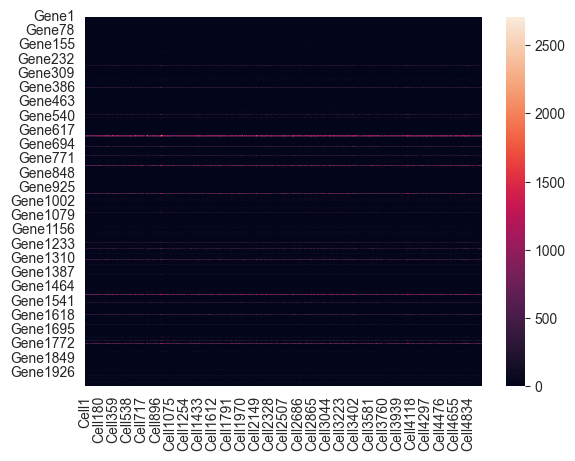

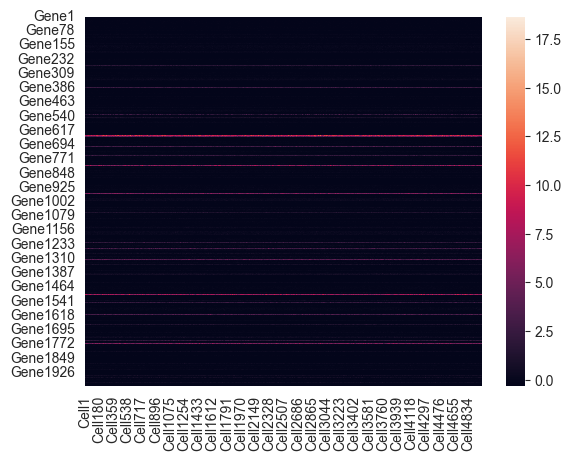

In [28]:
from scipy.stats import zscore
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
df=pd.read_csv('data.tsv', sep='\t')
df2=zscore(df)
ax = sns.heatmap(df)
plt.show()
ax2 = sns.heatmap(df2)
plt.show()

## 2) Train a MLP on the data to classify rna samples into one of the two cell types.
### 2.1) implement following MLP model in sequential fashion.

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2000, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = x.view(-1, 2000)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

### 2.2) Instantiate (and name) the MLP model as `model`, Stochastic Gradient Descent optimizer as `optimizer` and Cross entropy loss as `criterion`. 


In [53]:
import torch
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

### 2.3) Fix the bug/s of the train method

In [54]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    for _ in range(epoch):
        # Loop over each batch from the training set
        for batch_idx, (data, target) in enumerate(train_loader):
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

train(10)

## 3) Evaluation
### 3.1) Change the previous codes to calculate test and train loss.

In [55]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    i = 1
    for _ in range(epoch):
        # Loop over each batch from the training set
        for batch_idx, (data, target) in enumerate(train_loader):
            output = model(data)
            loss = criterion(output, target)
            if i % log_interval == 0:
                print(f'Train Loss: {loss.item()}')
            i += 1
            loss.backward()
            optimizer.step()
    # Calculate test loss
    test_loss = 0
    correct = 0
    for data, target in train_loader:
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(train_loader.dataset)
    print(f'Test Loss: {test_loss}')

train(10)

Train Loss: 1.6478034257888794
Train Loss: 0.7125939130783081
Train Loss: 1.7303181886672974
Train Loss: 1.1246923208236694
Train Loss: 2.122441291809082
Train Loss: 1.4076497554779053
Train Loss: 1.8930743932724
Test Loss: 0.02981240177154541


### 3.2) Change the previous codes to calculate Accuracy, specificity, sensitivity, and AUC for test set.

In [56]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
def test():
    # Set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in train_loader:
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            y_true.append(target)
            y_pred.append(pred)
    test_loss /= len(train_loader.dataset)
    print("Test loss: ", test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Specificity: ", recall_score(y_true, y_pred, pos_label=0))
    print("Sensitivity: ", recall_score(y_true, y_pred))
    print("AUC: ", roc_auc_score(y_true, y_pred))

test()

Test loss:  tensor(0.0298)

Test set: Average loss: 0.0298, Accuracy: 2513/5000 (50%)

Accuracy:  0.5026
Specificity:  0.0
Sensitivity:  1.0
AUC:  0.5
